# Data 604 Final Project
## Super Market Checkout Line
## Vic Chan


### Problem and Significance

In this project I will be tackeling the problem of waiting in line in a store and the question of is it better to switch to a shorter line after a certain amount of time or is it better to wait your turn in line. I will be running multiple simulations to see if waiting or switching is better based on different parameters. I will be generating different completion times for customers ahead and randomly assigning customers to different lines. I also will be randomly adding new customers to the shortest line to add realism to the model as in the real world people are constantly being added to different checkout lines.

### Setup

The target user has two choices based on X amount of time
- The target user stays in their line
- The target moves to the shorter line

We will be measuring how long the target user took to checkout depending on different variables
- How many lines are open
- How many people are in each Line
- How long each customer in front takes to checkout (randomly generated for 1 - 5 minutes per customer)
- How likely new customers are being added to the shortest line

### Flow Chart Model

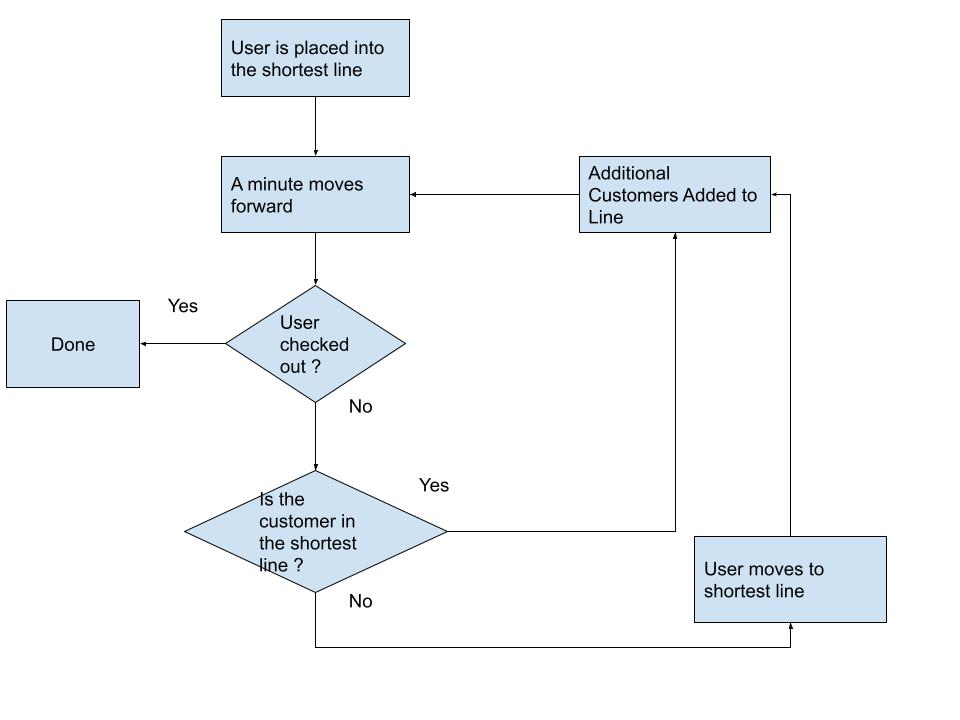

In [2]:
from IPython.display import Image
Image(filename='Flow Chart.jpg')

In [79]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
class Customer:

    def __init__(self, cust_num, line_num, min_checkout_time = 1, max_checkout_time = 5, me = False) -> None:
        self.cust_num = cust_num
        self.line_num = line_num

        if me:
            self.me = True
            self.checkout_time = 1
        else:
            self.me = False
            self.checkout_time = random.randint(min_checkout_time, max_checkout_time)

    def __str__(self):
        return f"Checkout Time: {self.checkout_time} | Me: {self.me}"

    def __repr__(self) -> str:
        return self.__str__()

In [5]:
class Line:
    def __init__(self, line_num, min_cust = 1, max_cust = 5) -> None:
        self.customers = []
        self.time = 0
        self.line_num = line_num

        for x in range(random.randint(min_cust, max_cust)):
            self.customers.append(Customer(x, line_num))

    def total_time(self):
        hold = 0
        for x in self.customers:
            hold = hold + x.checkout_time

        return hold

    def append_customer(self, me = False):

        cust = Customer(len(self.customers), self.line_num, me = me)

        self.customers.append(cust)

        if me:
            return cust

    def step(self):

        if len(self.customers) == 0:
            self.time = 0
            return

        self.time = self.time + 1

        if self.time >= self.customers[0].checkout_time:
            self.customers.pop(0)
            self.time = 0

            for id, customer in enumerate(self.customers):
                customer.cust_num = id

        


In [9]:
class Store_Simulation:
    def __init__(self, lines = 5, log = False) -> None:
        self.lines = []
        self.log = log

        for x in range(lines):
            self.lines.append(Line(x))

    def shortest_line(self):
        line_length = []
        for line in self.lines:
            line_length.append(len(line.customers))

        return line_length.index(min(line_length))

    def add_rand_cust(self, probability = 0):
        if np.random.binomial(n=1, p=probability) == 1:
            self.lines[self.shortest_line()].append_customer()
            return True
        else:
            return False

    def move_me_to_shortest_line(self, me: Customer):
        short = self.shortest_line()
        if me.line_num == short:
            if self.log:
                print('Already on shortest line')
            return me
        else:
            self.lines[me.line_num].customers.pop(me.cust_num)
            return self.lines[short].append_customer(me = True)

    def has_checked_out(self):
        for line in self.lines:
            for customer in line.customers:
                if customer.me:
                    return False
        return True

    def lines_step(self):
        if self.log:
            print('Stepping')
        for line in self.lines:
            line.step()

    def print(self):
        for x in self.lines:
            print(x.customers)

    def run(self, time_till_move = 10, rand_cust_prob = 0):
        # In the beginning need to add our own customer into a line
        # me = Customer(me=True)
        # self.lines[self.shortest_line()].append(me)

        me = self.lines[self.shortest_line()].append_customer(me=True)

        time = 0
        time_since_me_move = 0

        while not self.has_checked_out():
            if self.log:
                self.print()
            self.lines_step()
            time = time + 1
            time_since_me_move = time_since_me_move + 1

            if time_since_me_move > time_till_move and not self.has_checked_out():
                if self.log:
                    print('Moving Lines')
                me = self.move_me_to_shortest_line(me)
                time_since_me_move = 0
            
            self.add_rand_cust(rand_cust_prob)

        return time

In [85]:
def move_simulations(cust_prob):
    hold = []

    for x in range(1, 11):
        store = Store_Simulation(lines = 5)
        results = store.run(time_till_move = x, rand_cust_prob = cust_prob)

        hold.append((x, results))

    return hold

In [87]:
def run_simulations():
    prob = [0, 0.2, 0.4, 0.8, 1]


    for id, x in enumerate(prob):
        results = []
        for _ in range(100):
            results = results + move_simulations(x) 

        df = pd.DataFrame(results, columns=['time_till_move', 'time_took'])
        
        plt.figure(id)
        ax = sns.boxplot(data=df, x="time_till_move", y="time_took") 
        ax.set(ylabel = 'Time Took To Checkout', xlabel = 'Time Until Move To Shortest Line', title = f"Waiting in line with Cust Prob {x}")

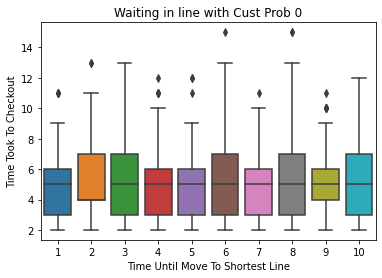

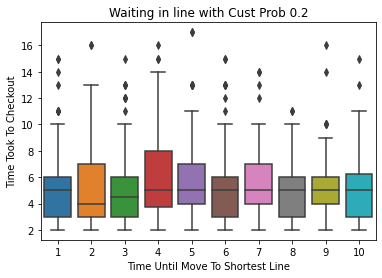

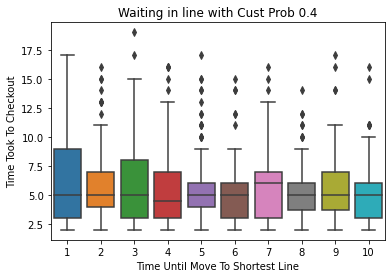

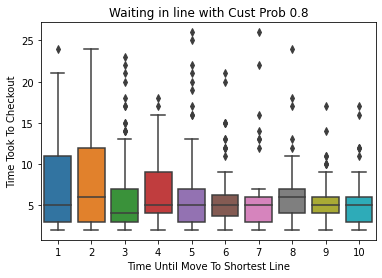

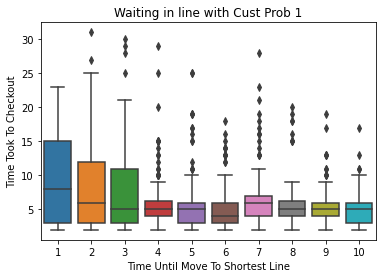

In [88]:
run_simulations()

### Validation of Model

I validated the model by adding multiple print statements throughout the simulation and printed out the board layout with every passing minute. I was able to verify based on the different parameters that new customers was being added to the shortest lines, and that the target user was switching to the shortest line after the allocated amount of time. I made sure that if the target user was already in the shortest line they would stay in their line, even after the allocated time has passed reseting the timer, as in the real world people would not leave their line if they are already on the shortest line.

### Conclusion and Findings

We can see from the results that waiting in line is general the best solution especially when there are based on all the bar charts belows. We can see that whether the target user moved to the shortest line after 1 minute of waiting or 10 minutes they usually had the same checkout time. Only when there is a higher probabilty of more customers entering the line does the waiting strategy works the best. We can see in the last chart with the title **Waiting in line with Cust Prob 1** shows that the more the customer switches lines the slower the checkout time is. This allows me to conclude that waiting in your current line is the best strategy even if you do now know how long the people in front of you will take. One thing that would be interesting to see is adding more open lines as the simulation is currently set up for 5 lines.